## 循环神经网络
到⽬前为⽌，我们遇到过两种类型的数据：表格数据和图像数据。对于图像数据，我们设计了专⻔的卷积神
经⽹络架构来为这类特殊的数据结构建模。换句话说，如果我们拥有⼀张图像，我们需要有效地利⽤其像素
位置，假若我们对图像中的像素位置进⾏重排，就会对图像中内容的推断造成极⼤的困难。  

最重要的是，到⽬前为⽌我们默认数据都来⾃于某种分布，并且所有样本都是独⽴同分布的（independently
and identically distributed，i.i.d.）。然⽽，⼤多数的数据并⾮如此。例如，⽂章中的单词是按顺序写的，如
果顺序被随机地重排，就很难理解⽂章原始的意思。同样，视频中的图像帧、对话中的⾳频信号以及⽹站上
的浏览⾏为都是有顺序的。因此，针对此类数据⽽设计特定模型，可能效果会更好。  

另⼀个问题来⾃这样⼀个事实：我们不仅仅可以接收⼀个序列作为输⼊，⽽是还可能期望继续猜测这个序列
的后续。例如，⼀个任务可以是继续预测2, 4, 6, 8, 10, . . .。这在时间序列分析中是相当常⻅的，可以⽤来预测
股市的波动、患者的体温曲线或者赛⻋所需的加速度。同理，我们需要能够处理这些数据的特定模型。  

简⾔之，如果说卷积神经⽹络可以有效地处理空间信息，那么本章的循环神经⽹络（recurrent neural network，
RNN）则可以更好地处理序列信息。循环神经⽹络通过引⼊状态变量存储过去的信息和当前的输⼊，从⽽可
以确定当前的输出。  

许多使⽤循环⽹络的例⼦都是基于⽂本数据的，因此我们将在本章中重点介绍语⾔模型。在对序列数据进⾏
更详细的回顾之后，我们将介绍⽂本预处理的实⽤技术。然后，我们将讨论语⾔模型的基本概念，并将此讨
论作为循环神经⽹络设计的灵感。最后，我们描述了循环神经⽹络的梯度计算⽅法，以探讨训练此类⽹络时
可能遇到的问题。


## 序列模型
想象⼀下有⼈正在看⽹⻜（Netflix，⼀个国外的视频⽹站）上的电影。⼀名忠实的⽤⼾会对每⼀部电影都给
出评价，毕竟⼀部好电影需要更多的⽀持和认可。然⽽事实证明，事情并不那么简单。随着时间的推移，⼈
们对电影的看法会发⽣很⼤的变化。事实上，⼼理学家甚⾄对这些现象起了名字：
* 锚定（anchoring）效应：基于其他⼈的意⻅做出评价。例如，奥斯卡颁奖后，受到关注的电影的评分
会上升，尽管它还是原来那部电影。这种影响将持续⼏个⽉，直到⼈们忘记了这部电影曾经获得的奖
项。结果表明（(Wu et al., 2017)），这种效应会使评分提⾼半个百分点以上。  

* 享乐适应（hedonic adaption）：⼈们迅速接受并且适应⼀种更好或者更坏的情况作为新的常态。例如，
在看了很多好电影之后，⼈们会强烈期望下部电影会更好。因此，在许多精彩的电影被看过之后，即使
是⼀部普通的也可能被认为是糟糕的。

* 季节性（seasonality）：少有观众喜欢在⼋⽉看圣诞⽼⼈的电影。

* 有时，电影会由于导演或演员在制作中的不当⾏为变得不受欢迎。

* 有些电影因为其极度糟糕只能成为⼩众电影。Plan9from Outer Space和Troll2就因为这个原因⽽臭名昭
著的。

简⽽⾔之，电影评分决不是固定不变的。因此，使⽤时间动⼒学可以得到更准确的电影推荐 (Koren, 2009)。
当然，序列数据不仅仅是关于电影评分的。下⾯给出了更多的场景。

* 在使⽤程序时，许多⽤⼾都有很强的特定习惯。例如，在学⽣放学后社交媒体应⽤更受欢迎。在市场开
放时股市交易软件更常⽤。

* 预测明天的股价要⽐过去的股价更困难，尽管两者都只是估计⼀个数字。毕竟，先⻅之明⽐事后诸葛
亮难得多。在统计学中，前者（对超出已知观测范围进⾏预测）称为外推法（extrapolation），⽽后者
（在现有观测值之间进⾏估计）称为内插法（interpolation）。

* 在本质上，⾳乐、语⾳、⽂本和视频都是连续的。如果它们的序列被我们重排，那么就会失去原有的意
义。⽐如，⼀个⽂本标题“狗咬⼈”远没有“⼈咬狗”那么令⼈惊讶，尽管组成两句话的字完全相同。

* 地震具有很强的相关性，即⼤地震发⽣后，很可能会有⼏次⼩余震，这些余震的强度⽐⾮⼤地震后的余
震要⼤得多。事实上，地震是时空相关的，即余震通常发⽣在很短的时间跨度和很近的距离内。

* ⼈类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。


## 统计工具
处理序列数据需要统计⼯具和新的深度神经⽹络架构。为了简单起⻅，我们以 图8.1.1所⽰的股票价格（富
时100指数）为例。  
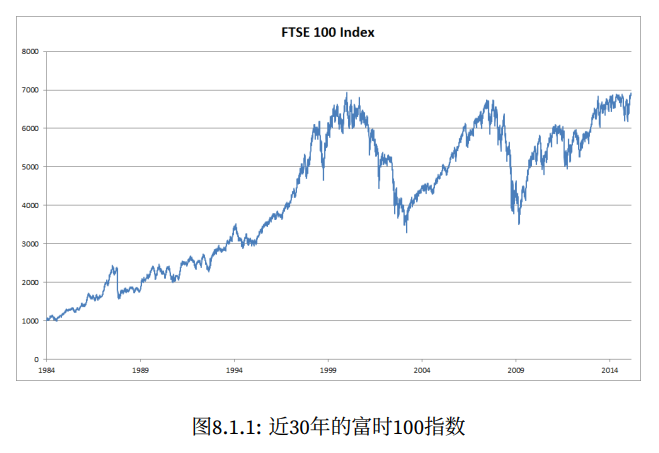  

其中，⽤xt表⽰价格，即在时间步（time step）t ∈ Z
+时，观察到的价格xt。请注意，t对于本⽂中的序列通常
是离散的，并在整数或其⼦集上变化。假设⼀个交易员想在t⽇的股市中表现良好，于是通过以下途径预测xt：  
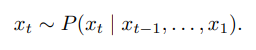

### 自回归模型
为了实现这个预测，交易员可以使⽤回归模型，例如在 3.3节中训练的模型。仅有⼀个主要问题：输⼊数据的
数量，输⼊xt−1, . . . , x1本⾝因t⽽异。也就是说，输⼊数据的数量这个数字将会随着我们遇到的数据量的增加
⽽增加，因此需要⼀个近似⽅法来使这个计算变得容易处理。本章后⾯的⼤部分内容将围绕着如何有效估计
P(xt | xt−1, . . . , x1)展开。简单地说，它归结为以下两种策略。

第⼀种策略，假设在现实情况下相当⻓的序列 xt−1, . . . , x1可能是不必要的，因此我们只需要满⾜某个⻓度
为τ的时间跨度，即使⽤观测序列xt−1, . . . , xt−τ。当下获得的最直接的好处就是参数的数量总是不变的，⾄少
在t > τ时如此，这就使我们能够训练⼀个上⾯提及的深度⽹络。这种模型被称为⾃回归模型（autoregressive
models），因为它们是对⾃⼰执⾏回归。  

第⼆种策略，如 图8.1.2所⽰，是保留⼀些对过去观测的总结ht，并且同时更新预测xˆt和总结ht。这就产⽣了
基于xˆt = P(xt | ht)估计xt，以及公式ht = g(ht−1, xt−1)更新的模型。由于ht从未被观测到，这类模型也被称
为 隐变量⾃回归模型（latent autoregressive models）。  

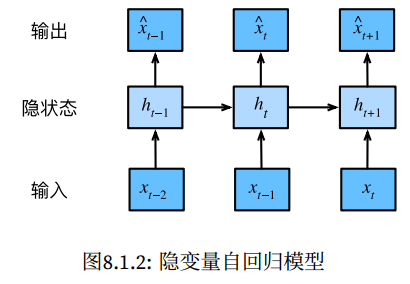

这两种情况都有⼀个显⽽易⻅的问题：如何⽣成训练数据？⼀个经典⽅法是使⽤历史观测来预测下⼀个未来
观测。显然，我们并不指望时间会停滞不前。然⽽，⼀个常⻅的假设是虽然特定值xt可能会改变，但是序列
本⾝的动⼒学不会改变。这样的假设是合理的，因为新的动⼒学⼀定受新的数据影响，⽽我们不可能⽤⽬前
所掌握的数据来预测新的动⼒学。统计学家称不变的动⼒学为静⽌的（stationary）。因此，整个序列的估计
值都将通过以下的⽅式获得：  

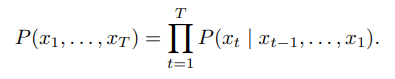

注意，如果我们处理的是离散的对象（如单词），⽽不是连续的数字，则上述的考虑仍然有效。唯⼀的差别是，
对于离散的对象，我们需要使⽤分类器⽽不是回归模型来估计P(xt | xt−1, . . . , x1)。

### 马尔可夫模型
回想⼀下，在⾃回归模型的近似法中，我们使⽤xt−1, . . . , xt−τ ⽽不是xt−1, . . . , x1来估计xt。只要这种是近似
精确的，我们就说序列满⾜⻢尔可夫条件（Markov condition）。特别是，如果τ = 1，得到⼀个 ⼀阶⻢尔可
夫模型（first-order Markov model），P(x)由下式给出：  

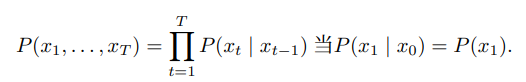

当假设xt仅是离散值时，这样的模型特别棒，因为在这种情况下，使⽤动态规划可以沿着⻢尔可夫链精确地
计算结果。例如，我们可以⾼效地计算P(xt+1 | xt−1)：  

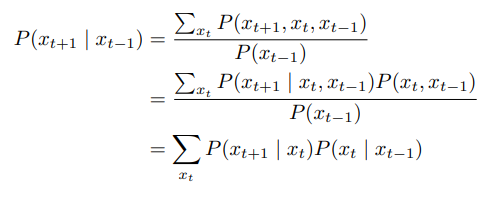  

利⽤这⼀事实，我们只需要考虑过去观察中的⼀个⾮常短的历史：P(xt+1 | xt, xt−1) = P(xt+1 | xt)。隐⻢尔
可夫模型中的动态规划超出了本节的范围，⽽动态规划这些计算⼯具已经在控制
算法和强化学习算法⼴泛使⽤。

### 因果关系
原则上，将P(x1, . . . , xT )倒序展开也没什么问题。毕竟，基于条件概率公式，我们总是可以写出：  
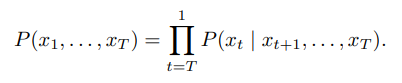  
事实上，如果基于⼀个⻢尔可夫模型，我们还可以得到⼀个反向的条件概率分布。然⽽，在许多情况下，数
据存在⼀个⾃然的⽅向，即在时间上是前进的。很明显，未来的事件不能影响过去。因此，如果我们改变xt，
可能会影响未来发⽣的事情xt+1，但不能反过来。也就是说，如果我们改变xt，基于过去事件得到的分布不
会改变。因此，解释P(xt+1 | xt)应该⽐解释P(xt | xt+1)更容易。例如，在某些情况下，对于某些可加性噪
声ϵ，显然我们可以找到xt+1 = f(xt) + ϵ，⽽反之则不⾏ (Hoyer et al., 2009)。⽽这个向前推进的⽅向恰好也
是我们通常感兴趣的⽅向。彼得斯等⼈ (Peters et al., 2017) 对该主题的更多内容做了详尽的解释，⽽我们的
上述讨论只是其中的冰⼭⼀⻆。


## 训练
在了解了上述统计⼯具后，让我们在实践中尝试⼀下！⾸先，我们⽣成⼀些数据：使⽤正弦函数和⼀些可加
性噪声来⽣成序列数据，时间步为1, 2, . . . , 1000。  


time: tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
x: tensor([-0.1206, -0.0918, -0.1883, -0.0112, -0.0785,  0.0169,  0.0232,  0.0409,
         0.0741, -0.2543])


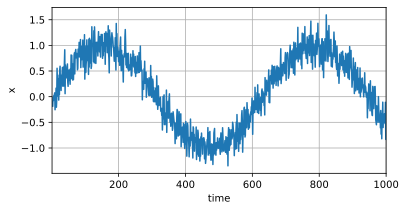

In [42]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 总共产⽣1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

print("time:",time[0:10])
print("x:",x[0:10])

接下来，我们将这个序列转换为模型的特征－标签（feature-label）对。基于嵌⼊维度τ，我们将数据映射为
数据对yt = xt 和xt = [xt−τ , . . . , xt−1]。这⽐我们提供的数据样本少了τ个，因为我们没有⾜够的历史记录来
描述前τ个数据样本。⼀个简单的解决办法是：如果拥有⾜够⻓的序列就丢弃这⼏项；另⼀个⽅法是⽤零填
充序列。在这⾥，我们仅使⽤前600个“特征－标签”对进⾏训练。


In [43]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

print("features:",features)
print("labels:",labels[0:10])

features: tensor([[-0.1206, -0.0918, -0.1883, -0.0112],
        [-0.0918, -0.1883, -0.0112, -0.0785],
        [-0.1883, -0.0112, -0.0785,  0.0169],
        ...,
        [-0.5046, -0.3319, -0.4338, -0.5258],
        [-0.3319, -0.4338, -0.5258, -0.1097],
        [-0.4338, -0.5258, -0.1097, -0.8326]])
labels: tensor([[-0.0785],
        [ 0.0169],
        [ 0.0232],
        [ 0.0409],
        [ 0.0741],
        [-0.2543],
        [ 0.0259],
        [-0.0517],
        [ 0.1650],
        [-0.2054]])


In [44]:
batch_size, n_train = 16, 600
# 只有前n_train个样本⽤于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


在这⾥，我们使⽤⼀个相当简单的架构训练模型：⼀个拥有两个全连接层的多层感知机，ReLU激活函数和平
⽅损失。

In [45]:
# 初始化⽹络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# ⼀个简单的多层感知机(4个特征，1个标签)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平⽅损失。注意：MSELoss计算平⽅误差时不带系数1/2
loss = nn.MSELoss(reduction='none')


In [46]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1, loss: 0.067869
epoch 2, loss: 0.055359
epoch 3, loss: 0.051173
epoch 4, loss: 0.051427
epoch 5, loss: 0.049854


## 预测
由于训练损失很⼩，因此我们期望模型能有很好的⼯作效果。让我们看看这在实践中意味着什么。⾸先是检
查模型预测下⼀个时间步的能⼒，也就是单步预测（one-step-ahead prediction）。

onestep_preds: tensor([[-0.1230],
        [-0.0941],
        [-0.0979],
        [-0.0033],
        [-0.0152],
        [ 0.0446],
        [-0.1172],
        [-0.0447],
        [-0.0107],
        [-0.0326]], grad_fn=<SliceBackward0>)


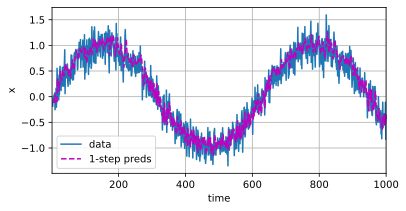

In [47]:
# 之前的600个特征用于训练，现在把全部的特征放入多层感知机用于预测标签
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        'x', legend=['data', '1-step preds'], xlim=[1, 1000],
        figsize=(6, 3))
print("onestep_preds:",onestep_preds[0:10])


正如我们所料，单步预测效果不错。即使这些预测的时间步超过了600 + 4（n_train + tau），其结果看起来
仍然是可信的。然⽽有⼀个⼩问题：如果数据观察序列的时间步只到604，我们需要⼀步⼀步地向前迈进：  
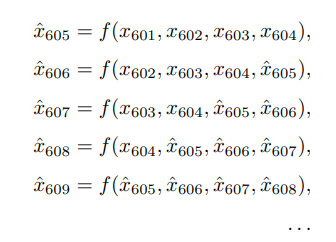  
通常，对于直到xt的观测序列，其在时间步t + k处的预测输出xˆt+k 称为k步预测（k-step-ahead-prediction）。
由于我们的观察已经到了x604，它的k步预测是xˆ604+k。换句话说，我们必须使⽤我们⾃⼰的预测（⽽不是原
始数据）来进⾏多步预测。让我们看看效果如何。

利用前4个特征预测第5个标签

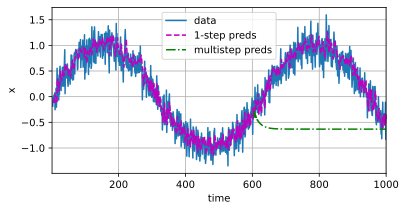

In [48]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

# 可视化
d2l.plot([time, time[tau:], time[n_train + tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy(),
        multistep_preds[n_train + tau:].detach().numpy()], 'time',
        'x', legend=['data', '1-step preds', 'multistep preds'],
        xlim=[1, 1000], figsize=(6, 3))


如上⾯的例⼦所⽰，绿线的预测显然并不理想。经过⼏个预测步骤之后，预测的结果很快就会衰减到⼀个常
数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤1之后，我们积累了⼀些错误ϵ1 = ¯ϵ。  
于是，步骤2的输⼊被扰动了ϵ1，结果积累的误差是依照次序的ϵ2 = ¯ϵ + cϵ1，其中c为某个常数，后⾯的预测
误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来24⼩时的天⽓预报往往相当准确，
但超过这⼀点，精度就会迅速下降。我们将在本章及后续章节中讨论如何改进这⼀点。  

基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看⼀下k步预测的困难。


In [49]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来⾃x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来⾃（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

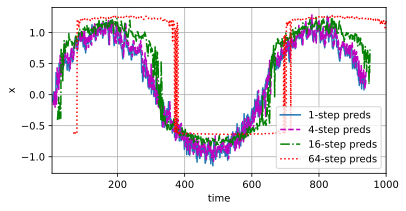

In [50]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
        [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6, 3))


以上例⼦清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。虽然“4步预测”看起来仍
然不错，但超过这个跨度的任何预测⼏乎都是⽆⽤的。

## 小结
* 内插法（在现有观测值之间进⾏估计）和外推法（对超出已知观测范围进⾏预测）在实践的难度上差别
很⼤。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进
⾏训练。
* 序列模型的估计需要专⻔的统计⼯具，两种较流⾏的选择是⾃回归模型和隐变量⾃回归模型。
* 对于时间是向前推进的因果模型，正向估计通常⽐反向估计更容易。
* 对于直到时间步t的观测序列，其在时间步t + k的预测（未来预测）输出是“k步预测”。随着我们对预测时间k值的
增加，会造成误差的快速累积和预测质量的极速下降。